# MultiCamera Paper Results Generation and Plotting

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import json
import pandas as pd
import numpy as np

In [2]:
aspect = 1.3
height = 2.5
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}

params = {'axes.labelsize': 'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

In [3]:
import sys
sys.path.append("../..") # Adds higher directory to python modules path.

from utilitysimv4 import Camera, InferenceJob, TrainingJob, MultiPeriodSimulator, fair_naive_scheduler, fair_dumb_scheduler, fair_sco_scheduler, fair_random_scheduler, inference_only_scheduler, single_camera_naive, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_infer_profile, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [4]:
# !!!!!!! CONFIGURE THESE PARAMS !!!!!!!!
dataset = 'waymo' #'cityscapes'
pred_mode = 'datadist'# 'datadist'

In [5]:
PROFILE_DIR = '/home/romilb/research/msr/results/profiling/new_profiling/{}/meta/profiles'.format(dataset)
INFERENCE_PROFILE_PATH = '../real_inference_profiles.csv'
INFERENCE_MAX_DEFAULT = 0.25
PLOT_PATH = './camready_plots/'
os.makedirs(PLOT_PATH, exist_ok=True)

In [6]:
l=os.listdir(PROFILE_DIR)
cities=[x.split('.')[0] for x in l]
print(cities)

[]


In [7]:
all_data = pd.read_csv('data_eval_multicam_all_data_{}_{}.csv'.format(dataset, pred_mode))

In [8]:
x=all_data[(all_data['sched']=='thief') & (all_data['res']==4) & (all_data['period']==100) & (all_data['use_oracle']==True)]# & (citywise_data['city']=="phx-21-40")]

In [9]:
tasks = [t for t in x.mean().keys() if "task" in t]

# Plotting

In [10]:
styles = ['^-', 'v-', 'o-']

In [11]:
PERIOD=100
USE_ORACLE_INFO = True
d = all_data
d = d[d['use_oracle'] == USE_ORACLE_INFO]
d = d[d['period'] == PERIOD]
scheds = ['inference_only', 'fair_sco','thief']
labels = ["No-retrain", "Ekya-resal", "Ekya"]

In [12]:
# Group data and create overall_mean col
plot_data = d.groupby(['sched', 'res', 'city']).mean()
tasks = [x for x in plot_data.columns if "task_" in x]
plot_data['overall_mean'] = plot_data[tasks].mean(axis=1)

In [13]:
plot_data['overall_mean'].mean(level=['sched', 'res'])

sched           res
fair_dumb       1      0.185056
                2      0.342452
                4      0.581648
                8      0.696109
fair_sco        1      0.295053
                2      0.575841
                4      0.755054
                8      0.823424
inference_only  1      0.283895
                2      0.377859
                4      0.399850
                8      0.399850
thief           1      0.380441
                2      0.654604
                4      0.810345
                8      0.853401
Name: overall_mean, dtype: float64

# Plot Acc vs Resources Provisioned

In [14]:
mean_acc_data = plot_data['overall_mean'].mean(level=['sched', 'res']).unstack(level=0)
std_acc_data = plot_data['overall_mean'].std(level=['sched', 'res']).unstack(level=0)

In [15]:
mean_acc_data['fair_sco_noepochs'] = 0
mean_acc_data['fair_sco_noepochs'].loc[1] = 0.24
mean_acc_data['fair_sco_noepochs'].loc[2] = 0.42
mean_acc_data['fair_sco_noepochs'].loc[4] = 0.69
mean_acc_data['fair_sco_noepochs'].loc[8] = 0.71


mean_acc_data['fair_sco'].loc[8] = 0.78

/home/romilb/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
mean_acc_data

sched,fair_dumb,fair_sco,inference_only,thief,fair_sco_noepochs
res,,,,,
1,0.185056,0.295053,0.283895,0.380441,0.24
2,0.342452,0.575841,0.377859,0.654604,0.42
4,0.581648,0.755054,0.399850,0.810345,0.69
8,0.696109,0.780000,0.399850,0.853401,0.71


In [17]:
scheds = ['inference_only', 'fair_sco_noepochs', 'fair_sco', 'thief' ]
labels = ["No-retrain", "Ekya-NoRes-NoEp", "Ekya-NoRes", "Ekya"]

In [18]:
mean_acc_data['thief'] - mean_acc_data['fair_dumb']

res
1    0.195386
2    0.312153
4    0.228697
8    0.157291
dtype: float64

/home/romilb/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


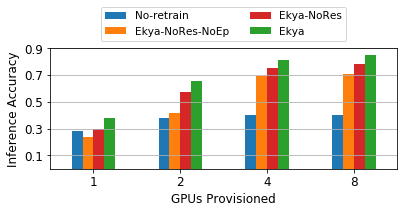

In [29]:
factor = 1.6
fig = plt.figure(figsize=[aspect*height*factor*1.1, height*factor*0.75])
ax = plt.gca()
ax = mean_acc_data.plot(y=scheds, kind='bar', ax=ax,colors =['C0', 'C1', 'C3', 'C2'],
                       label = labels)#, yerr=std_acc_data)

lgd = ax.legend(loc="lower center", bbox_to_anchor=(0,1.02,1,0.2), ncol=2, prop={'size': 10.5})
ax.set_ylabel('Inference Accuracy')
ax.set_xlabel('GPUs Provisioned')

# x_tick_range = range(1,9)
# ax.set_xticks(x_tick_range)
# ax.set_xticklabels(["{:d}".format(x) for x in x_tick_range])
# ax.set_xlim([0.8, 8.2])

y_tick_range = np.arange(0.1,0.91,0.2)
ax.set_yticks(y_tick_range)
ax.set_yticklabels(["{:.1f}".format(x) for x in y_tick_range])
plt.tight_layout()
ax.yaxis.grid(True)
plt.xticks(rotation='horizontal')
plt.savefig(os.path.join(PLOT_PATH, "ablation_{}.pdf".format(dataset)), bbox_inches='tight')

In [23]:
PLOT_PATH

'./camready_plots/'